# **Đồ án cuối kỳ môn Phân tích dữ liệu thông minh**

# **A. Thông tin chung**

## 1. Thông tin nhóm:
**Tên nhóm: Anadata**

**Thành viên**
- 20120089 - Lê Xuân Hoàng
- 20120422 - Nguyễn Thị Ánh Tuyết
- 20120460 - Lê Nguyễn Hải Dương
- 20120494 - Lê Xuân Huy
- 20120521 - Trần Thị Phương Linh

## 2. Phân công công việc
| MSSV | Họ tên | Công việc | Mức độ hoàn thành |
|---|---|---|---|
| 20120089 | Lê Xuân Hoàng | Khám phá dữ liệu, quay video | 100% |
| 20120422 | Nguyễn Thị Ánh Tuyết | Tìm hiểu model, quay và edit video | 100% |
| 20120460 | Lê Nguyễn Hải Dương | Tìm hiểu model và viết báo cáo | 100% |
| 20120494 | Lê Xuân Huy | Tìm hiểu model và code | 100% |
| 20120521 | Trần Thị Phương Linh | Tiền xử lý dữ liệu | 100% |

## 3. Giới thiệu đồ án
Đồ án được dựa trên cuộc thi [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) trên Kaggle

Twitter đã trở thành một kênh liên lạc quan trọng trong trường hợp khẩn cấp.

Sự phổ biến của điện thoại thông minh cho phép mọi người thông báo các trường hợp khẩn cấp mà họ đang quan sát thấy trong thời gian thực. Do đó, nhiều tổ chức quan tâm đến việc xây dựng một chương trình tự động theo dõi Twitter nhằm phát hiện các tin khẩn cấp được người dùng đăng lên Twitter (chẳng hạn như các tổ chức cứu trợ thảm họa và hãng thông tấn báo chí).

Tuy nhiên, không phải lúc nào bài đăng của người dùng cũng có thể xác định rõ đó có thực sự thông báo về một thảm họa hay không.

Vậy nên trong cuộc thi này, nhóm cần phải xây dựng một mô hình học máy dự đoán Tweet nào nói về thảm họa thực sự và Tweet nào không với tập dữ liệu gồm 10000 bài tweet đã được phân loại thủ công.

# **B. Nội dung đồ án**

## 1. Import thư viện cần thiết

Gói neattext lỗi khi cài đặt bằng conda nên không để vào file requirements.txt. Các gói còn lại bao gồm cả jupyter được viết ở file requirements.txt, các gói đó cần được cài đặt trước khi mở file notebook này

In [303]:
!pip install neattext

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
import neattext as nt
from collections import Counter

## 2. Đọc dữ liệu

Tiến hành đọc dữ liệu từ train.csv và test.csv và lưu vào 2 biến train_df và test_df

In [305]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Hãy xem thử chúng ta đã đọc đúng dữ liệu chưa bằng cách in ra kích thước và tên các cột

In [306]:
print('Train data shape:', train_df.shape)
print('Train columns:', train_df.columns)
print('Test data shape:', test_df.shape)
print('Test columns:', test_df.columns)

Train data shape: (7613, 5)
Train columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Test data shape: (3263, 4)
Test columns: Index(['id', 'keyword', 'location', 'text'], dtype='object')


## 3. Tiền xử lý dữ liệu

### 3.1. Xử lý các dữ liệu bị lặp

Chúng ta quan tâm đến những dòng trong cột "text" có dữ liệu bị lặp, những dòng lặp lại như thế này là không cần thiết khi xây dựng mô hình nên chúng ta cần loại bỏ nó, trước hết hãy cùng nhìn xem có bao nhiêu dòng như vậy.

In [307]:
print('Number of duplicated text on train data: ',train_df.duplicated(['text']).sum())
print('Number of duplicated text on test data: ',test_df.duplicated(['text']).sum())

Number of duplicated text on train data:  110
Number of duplicated text on test data:  20


Hãy nhìn rõ hơn những dòng đó có dữ liệu như thế nào

In [308]:
train_df[train_df['text'].duplicated() == True].sort_values(by=['text'])

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1


Ta nhận thấy rằng có môt số dòng có cùng text nhưng target khác nhau, việc này sẽ gây mâu thuẫn và dẫn đến dự đoán kết quả sai khi chạy mô hình. Việc chúng ta cần làm là đối với những dòng như vậy, chọn target theo số đông sau đó xem thử kết quả như thế nào.

In [309]:
train_df['target'] = train_df.groupby('text')['target'].transform(lambda x: x.mode().iat[0])
train_df[train_df['text'].duplicated() == True].sort_values(by=['text'])

,id,keyword,location,text,target
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,0
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,0


Rất tốt, bây giờ với mỗi text thì chỉ có một target duy nhất, nhưng vẫn còn nhiều dòng có target trùng nhau, hãy drop các dòng đó để mỗi text chỉ lưu giữ 1 dòng duy nhất.

In [310]:
train_df = train_df.drop_duplicates(subset=['text'])
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


Bây giờ dữ liệu chỉ còn 7503 dòng so với ban đầu là 7613 dòng, ở phía trên ta cũng đã in ra và thấy được số dòng bị trùng lặp là 110, như vậy bây giờ dữ liệu đã không còn dòng nào có text bị lặp lại nữa.

### 3.2. Xử lý dữ liệu bị thiếu



Trước khi đi vào xử lý, hãy nhìn sơ qua dữ liệu chúng ta bị thiếu những gì. Dưới đây là hàm `missing_ratio(df)` trả về biểu đồ phần trăm dữ liệu thiếu của các cột có dữ liệu thiếu trong dataframe `df`

In [311]:
def missing_ratio(_df):
    missing_cols = _df.columns[_df.isnull().any()]
    plt.subplots(figsize=(6, 6))
    missing_ratio = _df[missing_cols].isnull().sum() * 100 / len(_df)
    missing_ratio.sort_values(inplace=True)
    missing_ratio.plot.bar(missing_ratio)
    return missing_ratio

Thử xem tập train có bao nhiêu dữ liệu thiếu

keyword      0.746368
location    33.080101
dtype: float64

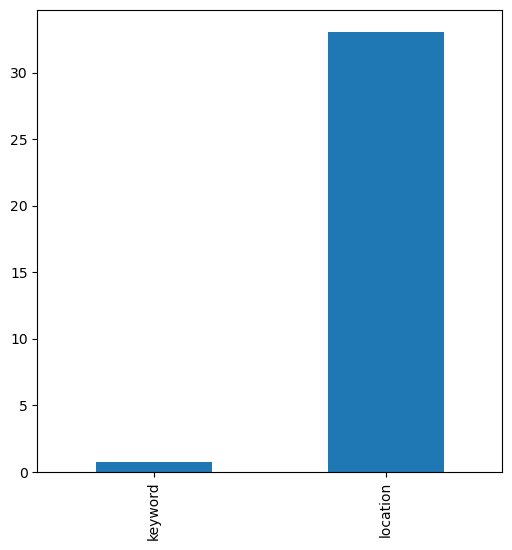

In [312]:
train_missing = missing_ratio(train_df)
train_missing

Thử xem tập test có bao nhiêu dữ liệu thiếu.

keyword      0.796813
location    33.864542
dtype: float64

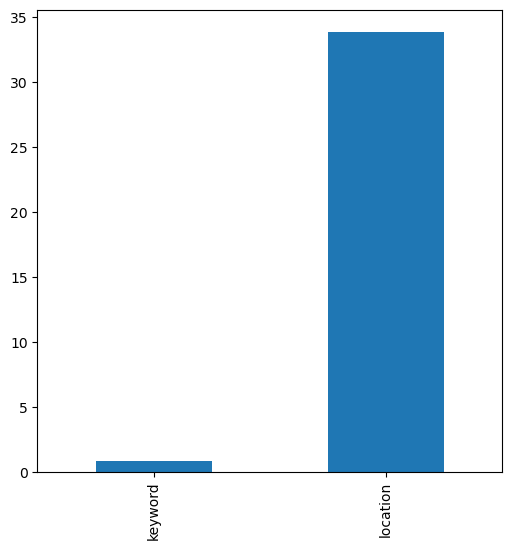

In [313]:
test_missing = missing_ratio(test_df)
test_missing

Bây giờ chúng ta sẽ thực hiện lấp đầy các giá trị trên bởi "None" để  không bị lỗi trong những xử lý sau này.

In [314]:
for col in ['keyword','location']:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

### 3.3. Làm sạch cột `text`


Trong cột text, có những từ không cần thiết hoặc những ký tự không cần thiết có thể ảnh hưởng đến kết quả của quá trình chạy mô hình như mention, email, urls, emojis,... chúng ta cần thực hiện loại bỏ những thứ này để chuỗi "sạch" hơn và từ đó đạt kết quả tốt hơn. Ở đây chúng ta sử dụng thư viện re(regular expression) và neattext (một thư viện dùng để làm sạch text).

In [315]:
def clean_text(text):
    text = re.sub(r"(?:\@)\S+", "", text) #Loại bỏ mention
    docx = nt.TextFrame(text=text)
    docx.normalize()
    docx.remove_urls()
    docx.remove_emojis()
    docx.remove_emails()
    docx.remove_puncts()
    docx.remove_special_characters()
    docx.fix_contractions()
    return docx.text

Thực hiện áp dụng hàm `clean_text()` vào tập train và tập test.

In [316]:
train_df['text']=train_df['text'].apply(lambda x: clean_text(x))
test_df['text']=test_df['text'].apply(lambda x: clean_text(x))

Bây giờ hãy nhìn xem các text trong tập train có dạng như thế nào.

In [317]:
train_df['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7604    WorldNews Fallen powerlines on Glink tram UPDA...
7605    on the flip side Im at Walmart and there is a ...
7606    Suicide bomber kills 15 in Saudi security site...
7608    Two giant cranes holding a bridge collapse int...
7612    The Latest More Homes Razed by Northern Califo...
Name: text, Length: 7503, dtype: object

Tương tự với tập test

In [318]:
test_df['text']

0                      Just happened a terrible car crash
1       Heard about earthquake is different cities sta...
2       there is a forest fire at spot pond geese are ...
3                   Apocalypse lighting Spokane wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES  SAFETY FASTENER...
3259    Storm in RI worse than last hurricane My citya...
3260                    Green Line derailment in Chicago 
3261            MEG issues Hazardous Weather Outlook HWO 
3262    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 3263, dtype: object

Tất cả đều nhìn có vẻ ổn, tuy nhiên phải check lại trong quá trình làm sạch chuối, có khi nào ta "làm sạch" đến mức mà chuỗi không còn gì hay không.

In [319]:
print(train_df[train_df['text'] ==""])
print(test_df[test_df['text'] ==""])

Empty DataFrame
Columns: [id, keyword, location, text, target]
Index: []
Empty DataFrame
Columns: [id, keyword, location, text]
Index: []


Số lượng cũng rất ít, chỉ có 2 dòng ở mỗi tập, ta tiến hành gán lại cho những dòng này

In [320]:
train_df.loc[train_df['text'] =="", "text"] = "None"
test_df.loc[test_df['text'] =="" , "text"] = "None"

## 4. Khám phá dữ liệu

### 4.1. Khám phá cột target

Trước hết, chúng ta nhìn xem phân bố cột target là như thế nào.

In [321]:
count_target = train_df.groupby("target").count()
count_target = count_target.rename(columns={"text": "count"})
fig = px.bar(count_target, x=count_target.index, y='count')
fig.update_layout(xaxis={'type': 'category'}, title={
            'text': 'Target column distribution',
            'x': 0.5,  # Giữa trục x
            'xanchor': 'center',  # Căn giữa theo trục x
            'yanchor': 'top'  # Căn theo trục y
        })
fig.show()

Nhận xét: Số lượng các tweet không phải là thảm họa lớn hơn số tweet là thảm họa. Nếu lấy random 1 tweet, khả năng tweet đó không phải là thảm họa sẽ cao hơn.

### 4.2. Khám phá cột keyword

Tiếp theo hãy nhìn xem các keyword liên quan như thế nào đối với target. Dưới đây là  biểu đồ trực quan top đầu và top cuối các key word được sắp xếp theo mean của target. Theo thứ tự từ trái sang phải là sự giảm dần của mean target, cột x là tên các keyword, cột y là số lượng của keyword đó.

In [322]:
top_key_word = train_df.groupby(["keyword"])["target"].mean().reset_index().sort_values(by = 'target', ascending=False)
top_key_word = top_key_word["keyword"]
#Chọn top 10 và 10 top cuôi
head_key_word = top_key_word.head(10)
tail_key_word = top_key_word.tail(10)

#Gom nhóm
target_by_keyword = train_df.groupby(["keyword", "target"])["text"].count().reset_index()
target_by_keyword = target_by_keyword.rename(columns={"text": "count"}) #SỐ lượng của text đặt tên là count
target_by_keyword['target'] = target_by_keyword['target'].astype(object)

from plotly.subplots import make_subplots


#Lọc ra và sắp xếp
head_data = target_by_keyword[target_by_keyword["keyword"].isin(head_key_word)]
head_data = head_data.sort_values(by="keyword", key=lambda x: x.map({key: i for i, key in enumerate(head_key_word)}))

tail_data = target_by_keyword[target_by_keyword["keyword"].isin(tail_key_word)]
tail_data = tail_data.sort_values(by="keyword", key=lambda x: x.map({key: i for i, key in enumerate(tail_key_word)}))

color_map = {0: 'green', 1: 'red'}

#Tạo subplot
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 10 High Probability Keywords", "Top 10 Low Probability Keywords"))

# Top 10 high probability keywords
fig.add_trace(px.bar(head_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[0], row=1, col=1)
fig.add_trace(px.bar(head_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[1], row=1, col=1)

# Top 10 low  probability keywords
fig.add_trace(px.bar(tail_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[0], row=1, col=2)
fig.add_trace(px.bar(tail_data, x="keyword", y='count', color = "target", color_discrete_map=color_map).data[1], row=1, col=2)

# Cột chồng
fig.update_layout(
    xaxis=dict(type='category'),
    showlegend=True,
    barmode='stack'

)

fig.update_traces(showlegend=True, row=1, col=1)
fig.update_traces(showlegend=False, row=1, col=2)


fig.show()

Nhận xét:
- Kết quả dường như rất hợp lý khi các keyword `weckage`, `debris`, `derailment` có tỷ lệ disaster chiếm đến 100%, các keyword như `outbreak`, `oil%20spill`, `typhoon` cũng chiếm tỷ lệ khá cao
- Bên cạnh đó, một số  keyword như `ruin`, `body%20bags`, `aftershock` thì hầu như không phải là thảm họa. Nếu như gặp phải các keyword trên thì ta gần như nắm chắc phần tự tin trả lời target là bao nhiêu.

### 4.3. Khám phá cột location

Hãy cùng nhìn xem địa điểm nào có nhiều tweet nhất.

In [323]:
top_location = train_df.groupby("location")["target"].count().sort_values(ascending=False).head(20)
top_location = top_location[top_location.index != "None"]

fig = px.bar(top_location, x=top_location.index, y=top_location.values)
fig.update_layout(xaxis={'type': 'category'},
                yaxis_title = "Count",
                xaxis_title = "Location",
                title={
                    'text': 'Top 20 location with the most tweets',
                    'x': 0.5,  # Giữa trục x
                    'xanchor': 'center',  # Căn giữa theo trục x
                    'yanchor': 'top'  # Căn theo trục y
                })


fig.show()

Nhận xét:
- Rất nhiều tweet được viết ở Mỹ (USA) và các thành phố, tiểu bang ở Mỹ
- Ngoài ra còn rất nhiều nơi khác, tóm lại là rất đa dạng.

Biểu đồ sẽ dễ so sánh giữa các địa phương, tuy nhiên muốn đếm số lượng tweet của nơi nào đó thì xem bảng dưới đây sẽ dễ hơn.

In [324]:
top_location

location
USA                104
New York            71
United States       50
London              45
Canada              29
Los Angeles, CA     26
UK                  26
Nigeria             23
India               21
Washington, DC      21
Mumbai              20
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
California          17
California, USA     15
New York, NY        15
Everywhere          15
Name: target, dtype: int64

Nhận xét: Có một số địa điểm vốn là giống nhau nhưng lại chia thành 2 tên khác nhau như USA, United States... Chúng ta cần gộp những địa điểm này lại thành 1. Vì số lượng quá nhiều nên ta sẽ chỉ xử lý những địa điểm nổi bật, còn lại sẽ gộp chung thành địa điểm "Others"

In [325]:
def clean_location(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x or 'NY' in x:
        return 'New York'
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Kenya' in x:
        return 'Kenya'
    elif x in top_location.index:
        return x
    else: return 'Others'

train_df['location'] = train_df['location'].apply(lambda x: clean_location(str(x)))
test_df['location'] = test_df['location'].apply(lambda x: clean_location(str(x)))

Sau khi làm sạch tên các địa điểm, hãy cùng nhìn lại xem tỷ lệ tweet là thảm họa ở mỗi địa phương ở trên. Dưới đây là biểu đồ cột thể hiện tỷ lệ một tweet là thảm họa ở các địa phương khác nhau, đường gạch ngang nét đứt màu đỏ là đường tham chiếu thể hiện tỷ lệ thảm họa trung bình của tweet trên toàn tập dữ liệu.

In [326]:
#Lọc dữ liệu
location_df = train_df[train_df["location"].isin(top_location.index)]
location_target = location_df.groupby("location")["target"].mean().sort_values(ascending=False)
mean_target = train_df["target"].mean()

fig = go.Figure()
#Biểu đồ cột
fig.add_trace(go.Bar(
    x=location_target.index,
    y=location_target.values,
))
#Thêm đường tham chiếu
fig.add_shape(
    type="line",
    x0=-0.5,
    y0=mean_target,
    x1=len(location_target) - 0.5,
    y1=mean_target,
    line=dict(
        color="red",
        width=2,
        dash="dash"
    )
)
#Chỉnh các tiêu đề
fig.update_layout(
    xaxis={'type': 'category'},
    yaxis_title="Target",
    xaxis_title="Location",
    title={
        'text': 'Mean target of locations with the most tweets',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

Nhận xét:
- Mumbai có tỷ lệ tweet là thảm họa cao đến dọa người, lớn hơn 0.8 và cao gấp đôi so với tỷ lệ trung bình. Tức là hầu như tweet nào ở đây trong tập dữ liệu cũng là nói về thảm họa. Các nơi như Nigeria, India cũng cao không kém
- Ba thành phố xếp cuối là London, Kenya, New York có tỷ lệ dưới trung bình tuy nhiên cũng không dưới nhiều quá mà cũng gần đường tham chiếu.

### 4.4. Khám phá cột text

In [327]:
#Loại bỏ stopword
def rm_stopword(text):
    docx = nt.TextFrame(text=text)
    docx.remove_stopwords()
    return docx.text

#Loại bỏ stopword
train_wt_stopword = train_df.copy()
train_wt_stopword['text']=train_wt_stopword['text'].apply(lambda x: rm_stopword(x))

Trước hết, cùng nhìn xem phân bố độ dài của cột text.

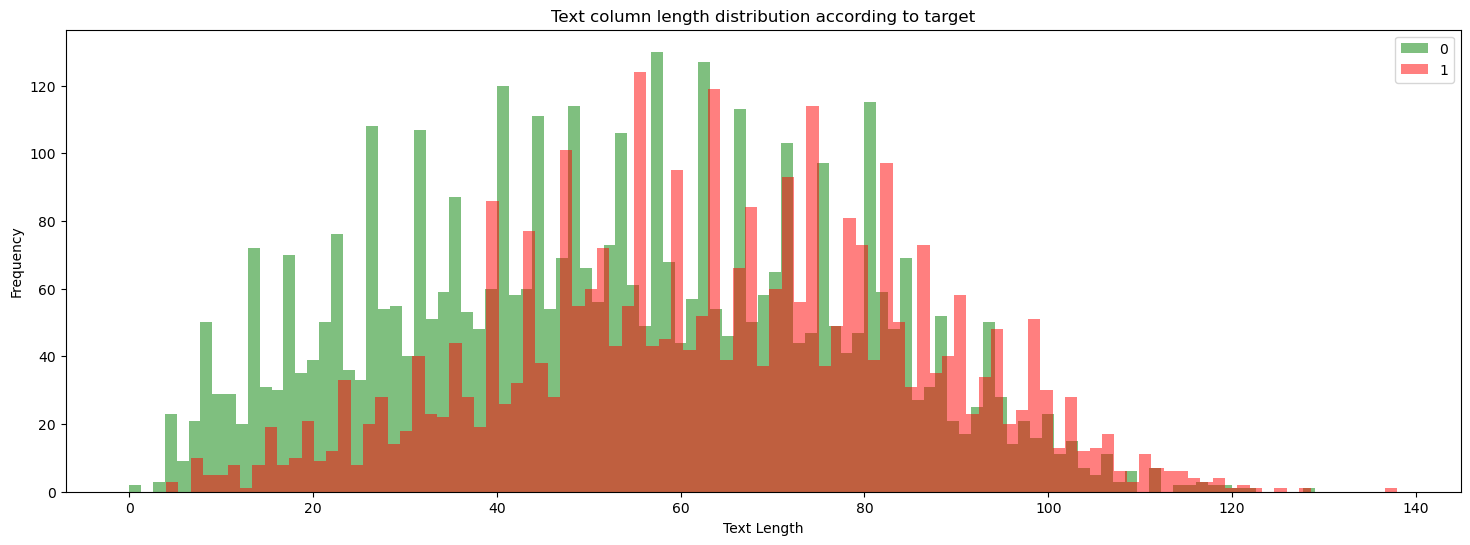

In [328]:
df_with_text_length = train_wt_stopword.copy()
df_with_text_length['text_length'] = df_with_text_length['text'].apply(len)


# Tách dữ liệu cho mỗi target
target_0 = df_with_text_length[df_with_text_length['target'] == 0]['text_length']
target_1 = df_with_text_length[df_with_text_length['target'] == 1]['text_length']

# Vẽ histogram
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.hist(target_0, bins=100, alpha=0.5, label='0', color = "green")
plt.hist(target_1, bins=100, alpha=0.5, label='1', color = "red")

# Đặt tên trục và tiêu đề
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title("Text column length distribution according to target")

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()

Nhìn chung, các tweet có độ dài dưới 60 thì có khả năng cao hơn là một tweet không phải thảm họa. Phần Biểu đồ có giá trị Text Length < 60 gần như là có màu xanh lá cây cao hơn. 

Số lượng từ trong mỗi câu phân bố như thế nào? Dưới đây là displot để trực quan.

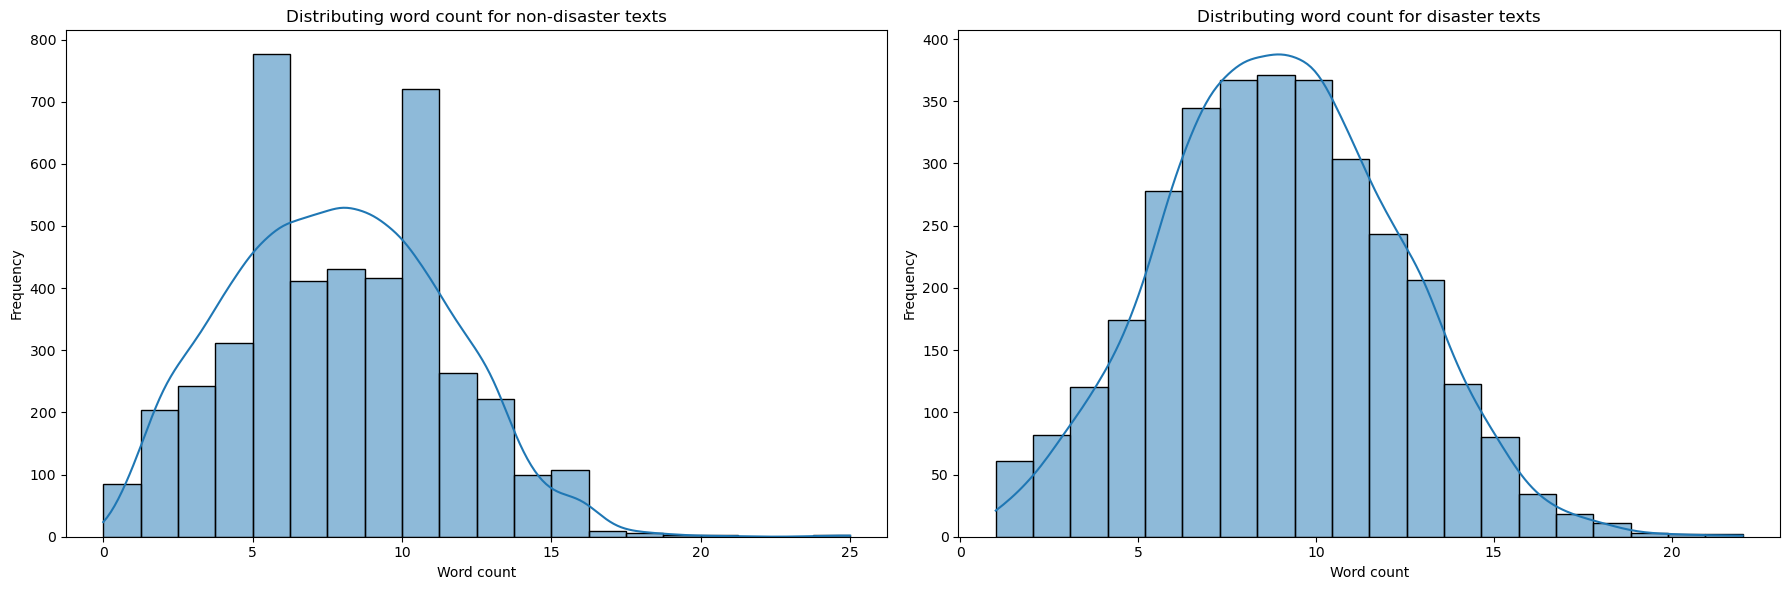

In [329]:
#Lọc dữ liệu
df_with_word_count = train_wt_stopword.copy()
df_with_word_count['word_count'] = train_wt_stopword['text'].str.split().map(lambda x: len(x))

#Vẽ biểu đồ cho target =  0
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 0], x='word_count', bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distributing word count for non-disaster texts')
axes[0].set_xlabel('Word count')
axes[0].set_ylabel('Frequency')

sns.histplot(data=df_with_word_count[df_with_word_count['target'] == 1], x='word_count', bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distributing word count for disaster texts')
axes[1].set_xlabel('Word count')
axes[1].set_ylabel('Frequency')

# Hiển thị biểu đồ
plt.tight_layout()

plt.show()

Số lượng từ của một disaster ít chênh lệch hơn so với số lượng từ của một non-disaster. Ở non-disaster có 2 giá trị bị trội là khoảng 5-6 từ và 10-11 từ. Nhìn chung, với một tweet từ dưới 11 từ thì nó có khả năng cao hơn là 1 non-disaste. So sánh ở tweet 5 từ ta thấy non disaster > 300, disaster khoảng 170, ở tweet 10 từ non-disaster > 400, disaster< 400. 

Tiếp theo, cùng xem đâu là các từ phổ biến trong một tweet? Hãy dùng wordcloud để trực quan điều này. 

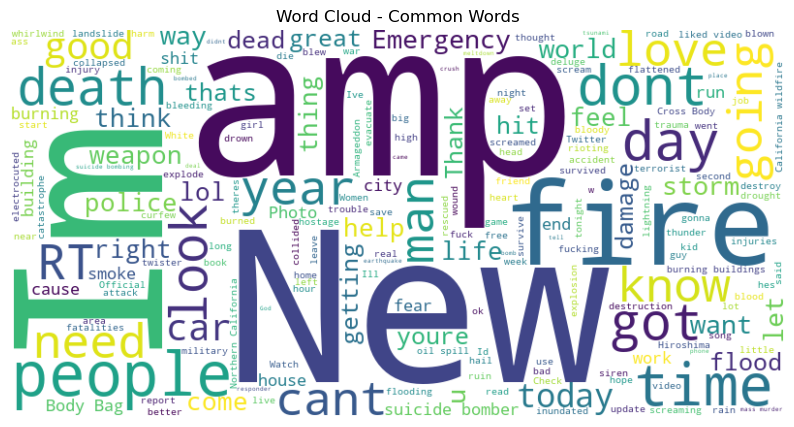

In [330]:
text_combined = ' '.join(train_df['text'])
text_combined = rm_stopword(text_combined)
#Sử dụng wordcloud để trực quan các từ phổ biến
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Common Words')
plt.show()


Hãy phân tích sâu hơn về các từ phổ biến. Đâu là những từ phổ biến cho một tweet disaster và non-disaster? Dưới đây là biểu đồ cột thể hiện số lượng các từ phổ biến trong các disaster tweet và non-disaster tweet

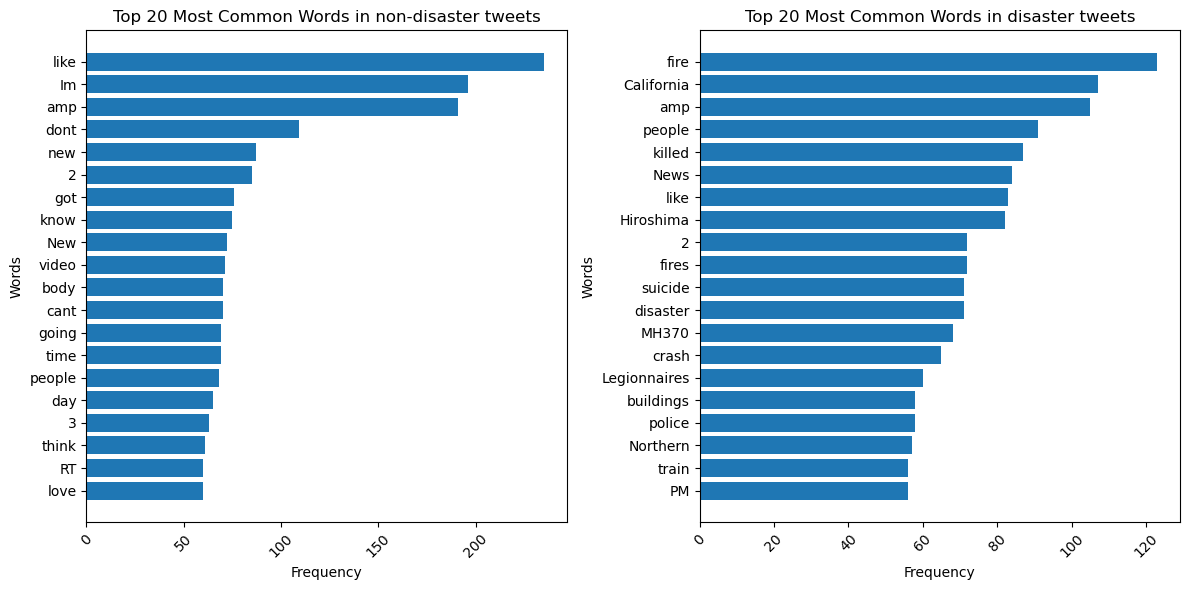

In [331]:
#Loại bỏ stopword
train_wt_stopword = train_df.copy()
train_wt_stopword['text']=train_wt_stopword['text'].apply(lambda x: rm_stopword(x))

# Tách các từ trong cột "text" với target = 0

words_0 = train_wt_stopword['text'][train_wt_stopword["target"] == 0].str.split()
all_words_0 = [word for sublist in words_0 for word in sublist]
word_counts_0 = Counter(all_words_0)
top_20_words_0 = word_counts_0.most_common(20)
word_list_0, word_count_0 = zip(*top_20_words_0)
word_list_0, word_count_0 = zip(*sorted(zip(word_list_0, word_count_0), key=lambda x: x[1], reverse=False))


# Tách các từ trong cột "text" với target = 1
words_1 = train_wt_stopword['text'][train_wt_stopword["target"] == 1].str.split()
all_words_1 = [word for sublist in words_1 for word in sublist]
word_counts_1 = Counter(all_words_1)
top_20_words_1 = word_counts_1.most_common(20)
word_list_1, word_count_1 = zip(*top_20_words_1)
word_list_1, word_count_1 = zip(*sorted(zip(word_list_1, word_count_1), key=lambda x: x[1], reverse=False))

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].barh(word_list_0, word_count_0)
axes[0].set_title('Top 20 Most Common Words in non-disaster tweets')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].barh(word_list_1, word_count_1)
axes[1].set_title('Top 20 Most Common Words in disaster tweets')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Kết quả nhìn có vẻ khá hợp lý khi các từ phổ biến trong các tweet non-disaster là các danh từ, động từ thường dùng trong cuộc sống hàng ngày như like, im, amp, new. Trong khi các từ trong disaster tweet mang nghĩa nguy hiểm, tiêu cực như fire, disaster,...

Hãy nhìn xem đối với các 2-grams thì như thế nào?

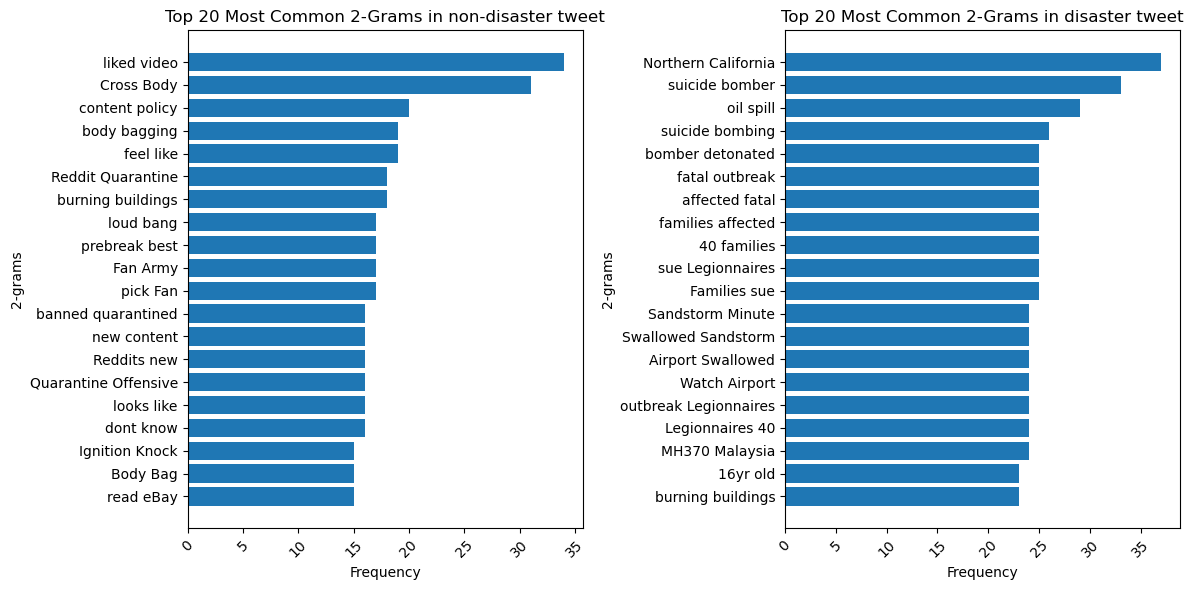

In [332]:
# Tách các từ trong cột "text" với target = 0 thành 2-gram
words_0 = train_wt_stopword['text'][train_wt_stopword["target"] == 0].str.split()
two_grams_0 = [word for sublist in words_0 for word in zip(sublist[:-1], sublist[1:])]
all_two_grams_0 = [' '.join(gram) for gram in two_grams_0]
two_gram_counts_0 = Counter(all_two_grams_0)
top_20_two_grams_0 = two_gram_counts_0.most_common(20)
two_gram_list_0, two_gram_count_0 = zip(*top_20_two_grams_0)
two_gram_list_0, two_gram_count_0 = zip(*sorted(zip(two_gram_list_0, two_gram_count_0), key=lambda x: x[1], reverse=False))

# Tách các từ trong cột "text" với target = 1 thành 2-gram
words_1 = train_wt_stopword['text'][train_wt_stopword["target"] == 1].str.split()
two_grams_1 = [word for sublist in words_1 for word in zip(sublist[:-1], sublist[1:])]
all_two_grams_1 = [' '.join(gram) for gram in two_grams_1]
two_gram_counts_1 = Counter(all_two_grams_1)
top_20_two_grams_1 = two_gram_counts_1.most_common(20)
two_gram_list_1, two_gram_count_1 = zip(*top_20_two_grams_1)
two_gram_list_1, two_gram_count_1 = zip(*sorted(zip(two_gram_list_1, two_gram_count_1), key=lambda x: x[1], reverse=False))

# Vẽ biểu đồ subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Biểu đồ cho target = 0
axes[0].barh(two_gram_list_0, two_gram_count_0)
axes[0].set_title('Top 20 Most Common 2-Grams in non-disaster tweet')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('2-grams')
axes[0].tick_params(axis='x', rotation=45)

# Biểu đồ cho target = 1
axes[1].barh(two_gram_list_1, two_gram_count_1)
axes[1].set_title('Top 20 Most Common 2-Grams in disaster tweet')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('2-grams')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Hầu hết các 2-grams về thảm họa đều có chứa tên thảm họa ở trong như 'bomber', 'oil spill', 'thunderstorm'. Ngoài ra những câu 2-grams có chứa 'califonia' có xu hướng là disaster, ta cũng đã gặp từ 'california' ở biểu đồ các từ phổ biến của disaster tweet ở phía trên.

## 5. Xây dựng mô hình

Bài toán này nhóm em thử với nhiều mô hình khác nhau, bao gồm các mô hình học máy truyền thống và mô hình học sâu.

Đối với các mô hình học máy truyền thống, nhóm em train trên các mô hình quen thuộc như: SVC, Random Forest, XgBoost, Navie Bayes và Logistic Regression.

Đối với mô hình học sâu, nhóm em sử dụng RoBERTa (Robustly Optimized BERT Approach), đây là một mô hình ngôn ngữ rất mạnh trong lĩnh vực xử lý ngôn ngữ tự nhiên (NLP)

### 5.1. Feature engineering

Chúng ta chỉ sử dụng thông tin từ cột `text` để train cho mô hình. Nhóm đã thử sử dụng kết hợp cả thông tin của cột `keyword` và `location` nhưng khi chạy thì ra kết quả thấp hơn đáng kể. Kết quả trong trường hợp chỉ sử dụng duy nhất cột `text` là tốt nhất.

In [172]:
x = train_df['text'].apply(lambda x: rm_stopword(x))
y = train_df['target']
x1 = test_df['text'].apply(lambda x: rm_stopword(x))

Tiếp theo, chúng ta tiến hành chia dữ liệu có được thành các tập train và test để phục vụ cho quá trình training và testing. Dữ liệu được chia với `test_size` = 0.2

In [173]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(x.values, y.values, test_size=.20, random_state=42, stratify=y)

TF-IDF là viết tắt của “Term Frequency, Inverse Document Frequency” - tạm dịch “Tần suất thuật ngữ, Tần suất tài liệu nghịch đảo”. Đó là một cách để chấm điểm tầm quan trọng của các từ (hoặc "các thuật ngữ") dựa trên tần suất xuất hiện của chúng xuất hiện trên nhiều tài liệu dựa trên quy tắc sau:

- Nếu một từ xuất hiện thường xuyên trong tài liệu, điều đó rất quan trọng. Cho từ này điểm cao.
- Nhưng nếu một từ xuất hiện trong nhiều tài liệu, thì đó không phải là mã định danh duy nhất. Cho từ đó điểm thấp.

Do đó, những từ phổ biến như `the` và `for` xuất hiện trong nhiều tài liệu sẽ được scaled down. Các từ xuất hiện thường xuyên trong một tài liệu sẽ được scaled up.

Với những giải thích trên, ta có công thức tính trọng số của một từ trong tài liệu trong ngữ liệu như sau:

$$w_{i,j} = tf_{i,j} \cdot idf_i = tf_{i,j} \cdot log(\frac {N}{df_i})$$

Trong đó:

- $tf_{i,j}$: Tần suất xuất hiện của i trong j
- $N$: Tổng số tài liệu
- $df_i$: Số tài liệu chứa i

**Reference:** https://medium.com/analytics-vidhya/an-introduction-to-tf-idf-using-python-5f9d1a343f77

Ta sử dụng TfidfVectorizer để tạo đặc trưng

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
train_features = vectorizer.fit_transform(train_texts)
test_features = vectorizer.transform(test_texts)

### 5.2. Xây dựng mô hình

Sau khi đã có các đặc trưng, việc còn lại chỉ là sử dụng các thư viện học máy như sklearn, gọi hàm rồi quăng dữ liệu vào và đợi kết quả thôi.

**Sử dụng SVM**

In [175]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Huấn luyện mô hình SVC
svc_model = SVC()
svc_model.fit(train_features, train_labels)

# Dự đoán kết quả
predictions_svc = svc_model.predict(test_features)

val_accuracy = accuracy_score(predictions_svc, test_labels)
print('Validation Accuracy:', val_accuracy)

Validation Accuracy: 0.8034643570952699


**Sử dụng RandomForest**

In [176]:
from sklearn.ensemble import RandomForestClassifier

# Huấn luyện mô hình RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(train_features, train_labels)

# Dự đoán kết quả
predictions_rf = rf_model.predict(test_features)

val_accuracy = accuracy_score(predictions_rf, test_labels)
print('Validation Accuracy:', val_accuracy)

Validation Accuracy: 0.7861425716189208


**Sử dụng XGBoost**

In [177]:
import xgboost as xgb

# Huấn luyện mô hình xbg
xbg_model = xgb.XGBClassifier()
xbg_model.fit(train_features, train_labels)

# Dự đoán kết quả
predictions_xgb = xbg_model.predict(test_features)

val_accuracy = accuracy_score(predictions_xgb, test_labels)
print('Validation Accuracy:', val_accuracy)

Validation Accuracy: 0.7828114590273151


**Sử dụng Multinomial Naive Baiyes**

In [178]:
from sklearn.naive_bayes import MultinomialNB

# Huấn luyện mô hình Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(train_features, train_labels)

# Dự đoán kết quả
predictions_nb = nb_model.predict(test_features)

val_accuracy = accuracy_score(predictions_nb, test_labels)
print('Validation Accuracy:', val_accuracy)

Validation Accuracy: 0.8007994670219853


**Sử dụng Logistic Regression**

In [179]:
from sklearn.linear_model import LogisticRegression

# Huấn luyện mô hình lr
lr_model = LogisticRegression()
lr_model.fit(train_features, train_labels)

# Dự đoán kết quả
predictions_lr = lr_model.predict(test_features)

val_accuracy = accuracy_score(predictions_lr, test_labels)
print('Validation Accuracy:', val_accuracy)

Validation Accuracy: 0.8054630246502332


**Nhận xét:**
- So sánh kết của giữa các mô hình thì có vẻ Random Forest và XgBoost kết quả có hơi bị thọt so với các mô hình còn lại.
- Có vẻ như mô hình dựa trên việc sử dụng Decision Tree không tốt lắm (tệ) trong bài toán text classification.
- Các mô hình chạy ra kết quả cũng tốt thật đấy, nhưng cũng chỉ tầm được mức 0.8 là cao nhất. Mục tiêu của nhóm là phải lọt được top 10%. Kết quả của các mô hình trên chỉ giúp đạt được top 50% (quá tệ), thế nên cần lựa chọn một mô hình tốt hơn cho bài toán này nếu muốn kết quả tốt hơn.

Nhóm cũng đã thử tìm cách để cải thiện kết quả của các mô hình truyền thống, như điều chỉnh lại 1 số chỗ ở phần tiền xử lý dữ liệu, điều chỉnh tham số mô hình,... Nhưng kết quả vẫn không thay đổi đáng kể 1 tý nào.

Sau khi tìm hiểu "1 ít" về lĩnh vực xử lý ngôn ngữ tự nhiên, nhóm phát hiện ra rằng các mô hình nổi bật trong xử lý ngôn ngữ tự nhiên đặc biệt là với task text classification đa số đều là các mô hình học sâu, trong đó cái tên xuất hiện nhiều nhất là BERT.

Ý tưởng để giải quyết bài toán là sử dụng mô hình đã pre-train từ một tập dữ liệu rất rất lớn trước, sau đó điều chỉnh tham số của mô hình (fine-tuning) rồi train trên downstream task (tức là bài toán của chúng ta). Việc mô hình ngôn ngữ đã pre-train thực sự đem lại hiệu quả rất lớn trong việc xử lý các tác vụ của xử lý ngôn ngữ tự nhiên.

BERT về cơ bản là một kiến trúc transformer được đào tạo để học cách biểu diễn ngôn ngữ. Nó chủ yếu khác với những mô hình ngôn ngữ trước đây là do khả năng hiểu được ngữ cảnh từ cả 2 phía của câu (trái và phải của chính từ đó) thay vì chỉ sử dụng thông tin từ trái sang phải (left-to-right) hoặc ngược lại. Từ đó, cho phép nắm bắt được sự phụ thuộc và ý nghĩa toàn diện hơn trong câu.

Sau khi thử BERT và các mô hình khác nhau được xây dựng dựa trên BERT, nhóm em đã thành công chọn một mô hình tốt nhất đó là RoBERTa.

RoBERTa tương tự như BERT về kiến trúc, nhưng nó đã trải qua một số cải tiến trong quá trình huấn luyện. Mục tiêu của RoBERTa là cải thiện hiệu suất so với BERT thông qua việc tinh chỉnh quá trình huấn luyện và sử dụng các siêu tham số khác nhau.

Một số khác biệt giữa RoBERTa và BERT:

- **Kích thước dữ liệu huấn luyện:** RoBERTa được tiền huấn luyện với lượng dữ liệu lớn hơn BERT gấp 10 lần (160GB và 16GB). Điều này giúp RoBERTa học được nhiều đặc trưng ngôn ngữ phổ quát hơn và cải thiện khả năng hiểu ngữ nghĩa.
- **Mặt nạ:** BERT được đào tạo với mặt nạ tĩnh, nghĩa là mặt nạ được khởi tạo 1 lần và được đưa vào huấn luyện trong mỗi epoch. Để có sự đa dạng hơn trong dữ liệu đào tạo cho mỗi epoch thì RoBERTa được áp dụng mặt nạ động. Hiệu suất của mô hình được đào tạo với mặt nạ động tốt hơn một chút hoặc ít nhất là tương đương với phương pháp ban đầu được sử dụng mặt nạ tĩnh.
- **Loại bỏ NSP:** RoBERTa không cần phải giới hạn đầu vào theo cặp câu và có thể sử dụng các cặp câu ngẫu nhiên để tăng đa dạng dữ liệu huấn luyện.

In [180]:
!pip install transformers

In [181]:
from transformers import RobertaTokenizer
from transformers import TFRobertaForSequenceClassification
import tensorflow as tf

In [182]:
x = train_df['text']
y = train_df['target']
x1 = test_df['text']
train_texts, test_texts, train_labels, test_labels = train_test_split(x.values, y.values, test_size=.20, random_state=42, stratify=y)

Nhóm em sử dụng RoBERTa cho bài toán này bằng việc import `TFRobertaForSequenceClassification` trong thư viện `transformers`.

Việc sử dụng mô hình từ thư viện này rất đơn giản, chỉ cần khởi tạo mô hình đã Pre-training với RoBERTa Base.

Sau khi khởi tạo mô hình, ta sẽ Encoding input cho phù hợp với đầu vào của mô hình (đây có thể xem như là bước tạo đặc trưng cho mô hình).

Tiếp theo sẽ là bước tinh chỉnh mô hình (fine-tuning) và train mô hình. Sau nhiều lần thử với các tham số khác nhau, nhóm em chọn learning rate (adam) là 3e-5, batch size là 32, và epoch là 2 thì sẽ có được kết quả tốt nhất.

Cuối cùng là evaluate model trên dữ liệu test để thu được kết quả và đánh giá

Khởi tạo mô hình và Tokenizer

In [183]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Encoding input cho phù hợp với đầu vào của mô hình

In [184]:
encoded_inputs = tokenizer(train_texts.tolist(), padding=True, truncation=True, return_tensors='tf')
labels = tf.constant(train_labels.tolist())

Điều chỉnh tham số cho mô hình

In [185]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

Compile và train model

In [186]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(encoded_inputs.input_ids, labels, epochs=3, batch_size=32)

Epoch 1/3
188/188 [==============================] - 132s 414ms/step - loss: 0.5020 - accuracy: 0.7577
Epoch 2/3
188/188 [==============================] - 72s 383ms/step - loss: 0.3811 - accuracy: 0.8412
Epoch 3/3
188/188 [==============================] - 71s 379ms/step - loss: 0.3173 - accuracy: 0.8727


Đánh giá kết quả của model

In [187]:
#Encode test input
test_inputs = tokenizer(test_texts.tolist(), padding=True, truncation=True, return_tensors='tf')

model.evaluate(
    x=test_inputs.input_ids,
    y=test_labels,
    batch_size=32
)

47/47 [==============================] - 9s 108ms/step - loss: 0.4006 - accuracy: 0.8548


[0.4005792737007141, 0.8547635078430176]

Kết quả của mô hình đạt được rất tốt, vượt trội rất nhiều so với các mô hình truyền thống. Với kết quả này nhóm tự tin đạt vào top 10%

Vì mô hình này tốt nhất nên nhóm sử dụng mô hình này để thực hiện việc dự đoán trên tập test và nộp kết quả đạt được lên Kaggle

In [188]:
#Encode predict input
predict_inputs = tokenizer(x1.tolist(), padding=True, truncation=True, return_tensors='tf')
# Make predictions
predictions = model.predict(predict_inputs.input_ids)

# Extract predicted labels
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

102/102 [==============================] - 16s 119ms/step


In [189]:
submission = pd.DataFrame({'id': test_df['id'], 'target': predicted_labels})
submission.to_csv('submission.csv', index=False)

Kết quả nhóm đạt dược: 0.